In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../clean_csv_data/clean_df.csv')
sessions_df = pd.read_csv('../clean_csv_data/sessions_df.csv')
scaled_sessions_df =pd.read_csv('../clean_csv_data/scaled_sessions_df.csv')

In [77]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
def normalize(x):
    norm = MinMaxScaler()
    return norm.fit_transform(x)

In [79]:
normalized_data_freq = normalize(session_freq)
normalized_data_dur = normalize(session_dur)
normalized_data_UL = normalize(session_DL)
normalized_data_DL = normalize(session_UL)
X = np.hstack((normalized_data_freq,normalized_data_dur,normalized_data_DL,normalized_data_UL))
X = normalize(X)

In [81]:
# Run a k-means (k=3) to classify customers in three groups of engagement.
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pickle

kmeans = KMeans(n_clusters=3).fit(X)
pickle.dump(kmeans, open("../models/user_engag_model.pkl", 'wb'))
kmeans = kmeans.predict(X)
X.shape

(106856, 4)

In [85]:
# Find the min,max and average of each metrics for each cluster
un_normalized_data = df_user_engagement.to_numpy()
clusters = {}
cluster_no = 3
container = []
for i in range(0,cluster_no):
    for x,y in zip(un_normalized_data,kmeans):    
        if y == i:
            container.append(x)
    clusters["cluster_"+str(i)] = np.array(container)
    container = []

In [91]:
#Aggregate user total traffic per application and derive the top 10 most engaged users per application
def find_agg(df:pd.DataFrame, agg_column:str, wanted_col:str,agg_metric:str, col_name:str, top:int, order=False )->pd.DataFrame:
    """ This function calculates aggregate of column """
    new_df = df.groupby(agg_column)[wanted_col].agg(agg_metric).reset_index(name=col_name).\
    sort_values(by=col_name, ascending=order)[:top]
    
    return new_df

app_names = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
agg_df_DL = {app_name: find_agg(data,'MSISDN/Number',app_name+' DL' , 'sum', "   DL "+app_name+" user", 10, order=False ).reset_index() for app_name in app_names}
agg_df_UL = {app_name: find_agg(data,'MSISDN/Number',app_name+' UL' , 'sum', "   UL of "+app_name+" user", 10, order=False ).reset_index() for app_name in app_names}

In [92]:
for app_name in app_names:
    print("Top 10 engaged users for ",app_name)
    print(agg_df_DL[app_name],"\n")

Top 10 engaged users for  Social Media
    index  MSISDN/Number     DL Social Media user
0   13526   3.362632e+10               42743837.0
1   92923   3.376054e+10               39297646.0
2   37052   3.365973e+10               34900444.0
3    6437   3.361489e+10               27749744.0
4   13180   3.362578e+10               26564121.0
5   65118   3.366716e+10               23753753.0
6  106137   3.378632e+10               23568655.0
7   70960   3.366907e+10               23477047.0
8     666   3.360313e+10               22776679.0
9   31331   3.365849e+10               22695673.0 

Top 10 engaged users for  Google
    index  MSISDN/Number     DL Google user
0   13526   3.362632e+10        116106455.0
1   13180   3.362578e+10        107904739.0
2    6437   3.361489e+10         93941708.0
3   37052   3.365973e+10         90958549.0
4   92923   3.376054e+10         88626532.0
5   76363   3.367588e+10         83002994.0
6  106137   3.378632e+10         78819810.0
7     666   3.360313e+10

,Apps,total DL,total UL
0,Social Media,2.673623e+11,4.903196e+09
1,Google,8.566107e+11,3.062427e+11
2,Email,2.668571e+11,6.961065e+10
3,Youtube,1.732628e+12,1.639576e+12
4,Netflix,1.731750e+12,1.638310e+12
5,Gaming,6.285438e+13,1.234535e+12
6,Other,6.272357e+13,1.230678e+12


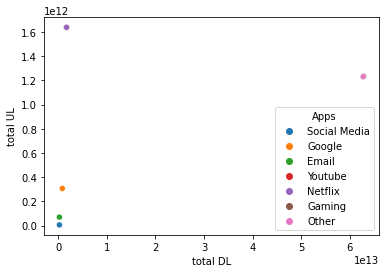

In [95]:
# Plot the top 3 most used applications using appropriate charts. To plot the top 3 most used applications, we will use the dl and ul volume of users.

used_app_DL = {app_name: data[app_name+" DL "].sum() for app_name in app_names}
used_app_UL = {app_name: cleaned_data[app_name+" UL"].sum() for app_name in app_names}
# used_app_UL = {app_name: cleaned_data[app_name+" UL (Bytes)"] for app_name in app_names}
df_used_apps = pd.DataFrame({"Apps":used_app_DL.keys(), "total DL": used_app_DL.values(), "total UL": used_app_UL.values()})

sn.scatterplot(data=df_used_apps, x="total DL",y="total UL", hue="Apps")
# df_used_apps["Total DL"]
# help(sn.scatterplot)
df_used_apps

In [96]:
#using the elbow method to find the optimal K
inertias = []
K = range(1,10)
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X) 
    # calulating inertia of the model with different ks
    inertias.append(kmeanModel.inertia_)

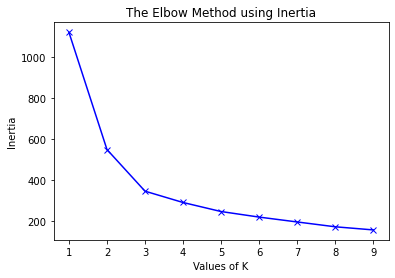

In [97]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()